### Data Source
All NHL shot and play-by-play data provided by [MoneyPuck.com](https://moneypuck.com/).  
Used under their open data policy.  


In [75]:
# import block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.calibration import calibration_curve
import seaborn as sns
from scipy.stats import gaussian_kde
# Show plots in notebook
%matplotlib inline

In [59]:
# load data
url = "https://peter-tanner.com/moneypuck/downloads/shots_2024.zip"
df = pd.read_csv(url)

Logistic Regression for Expected Goal

In [60]:
# features and target
features = ['xCord','yCord','shotAngle','shotType','shotDistance','shotRebound','shotRush']
target = 'goal'

In [61]:
# model dataframe
df_model = df[features + [target,'xGoal']].copy()
df_model.dropna(inplace=True)

In [62]:
# train test split
X = df_model.drop(columns=[target,'xGoal'])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.dtypes)

xCord             int64
yCord             int64
shotAngle       float64
shotType         object
shotDistance    float64
shotRebound       int64
shotRush          int64
dtype: object


In [63]:
# one categorical column
# Identify categorical columns
categorical_cols = ['shotType']  # add others if needed

# One-hot encode
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure both train and test have same columns
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

In [64]:
# fit model- logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_enc,y_train)

LogisticRegression(max_iter=1000)

In [65]:
# get predictions, check MSE and R^2 (not very useful for logsitic)
y_pred = model.predict(X_test_enc)
print('MSE:', mean_squared_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

MSE: 0.06971750936723782
R^2: -0.07494229985970935


In [66]:
# predicted probabilities
y_prob = model.predict_proba(X_test_enc)[:, 1]  # probability of goal
print('Brier score:', brier_score_loss(y_test, y_prob))
print('ROC AUC:', roc_auc_score(y_test, y_prob))

Brier score: 0.06271152226757362
ROC AUC: 0.698001430998459


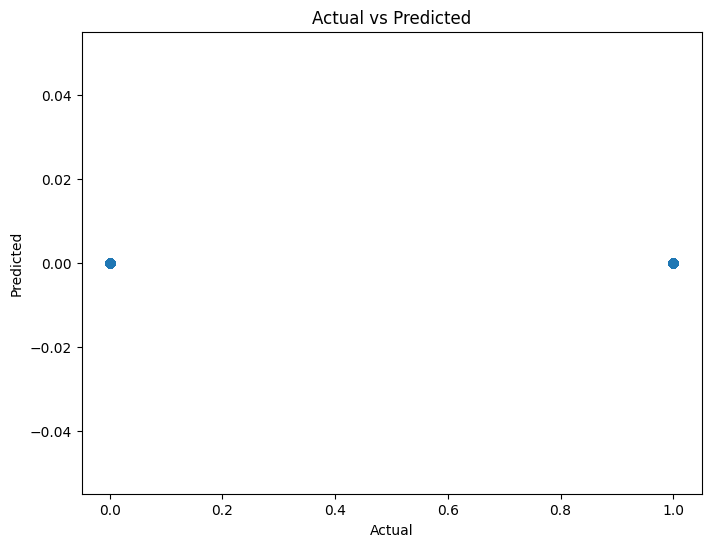

In [67]:
# scatter plot actual vs predicted (not very helpful here)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

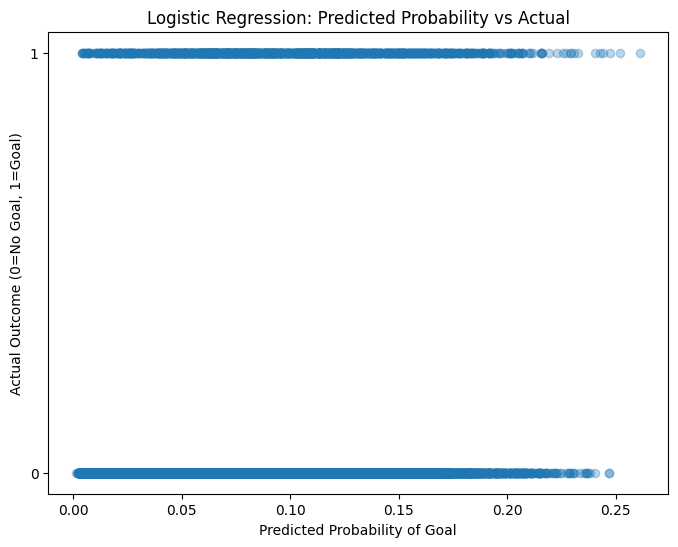

In [68]:
# plot of probabilities
plt.figure(figsize=(8,6))
plt.scatter(y_prob, y_test, alpha=0.3)
plt.xlabel('Predicted Probability of Goal')
plt.ylabel('Actual Outcome (0=No Goal, 1=Goal)')
plt.title('Logistic Regression: Predicted Probability vs Actual')
plt.yticks([0,1])
plt.show()

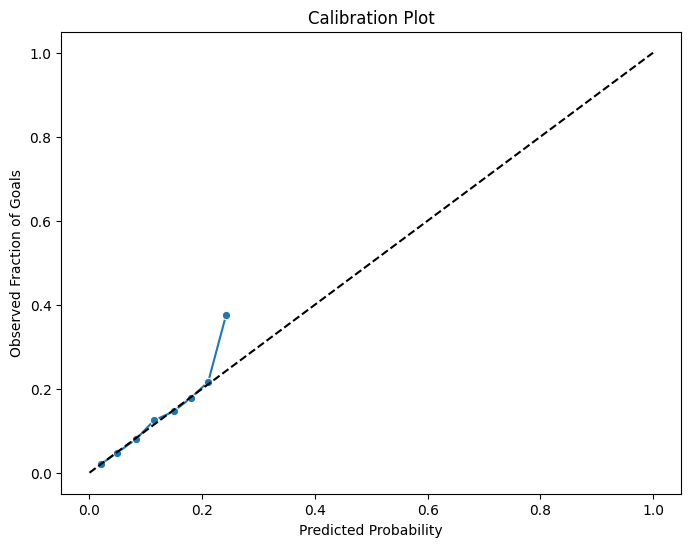

In [69]:
# calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=30)

plt.figure(figsize=(8,6))
sns.lineplot(x=prob_pred, y=prob_true, marker='o')
plt.plot([0,1], [0,1], 'k--')  # reference line
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Fraction of Goals')
plt.title('Calibration Plot')
plt.show()

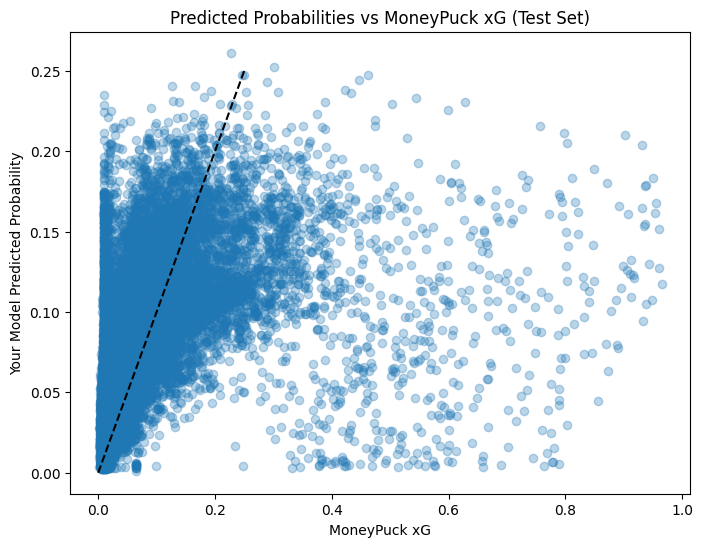

In [71]:
# compare to MoneyPuck's xGoal model
# Get the corresponding xGoal values for the test set
xgoal_test = df_model.loc[X_test_enc.index, 'xGoal']

# Now plot
plt.figure(figsize=(8,6))
plt.scatter(xgoal_test, y_prob, alpha=0.3)
plt.plot([0,0.25], [0,0.25], 'k--')  # diagonal reference
plt.xlabel("MoneyPuck xG")
plt.ylabel("Your Model Predicted Probability")
plt.title("Predicted Probabilities vs MoneyPuck xG (Test Set)")
plt.show()


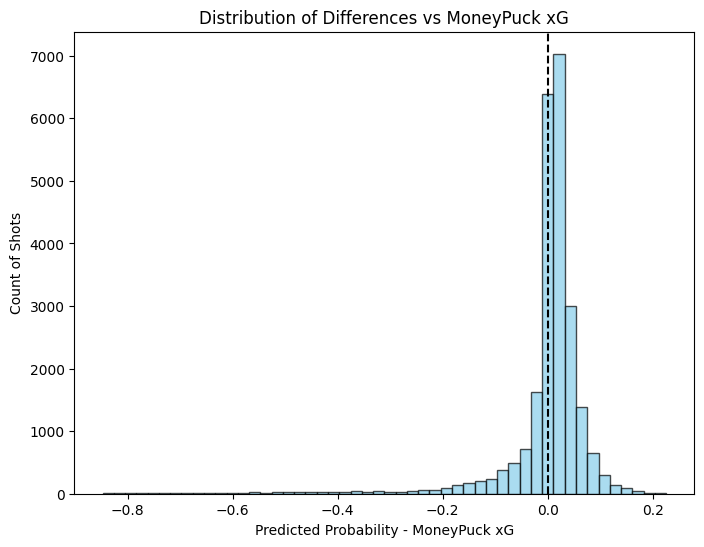

In [72]:
# plot absolute difference vs MoneyPuck
diff = y_prob - xgoal_test
abs_diff = np.abs(diff)

plt.figure(figsize=(8,6))
plt.hist(diff, bins=50, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Predicted Probability - MoneyPuck xG")
plt.ylabel("Count of Shots")
plt.title("Distribution of Differences vs MoneyPuck xG")
plt.show()

MSE vs MoneyPuck xG: 0.00810338886775085
MAE vs MoneyPuck xG: 0.04393474798814009


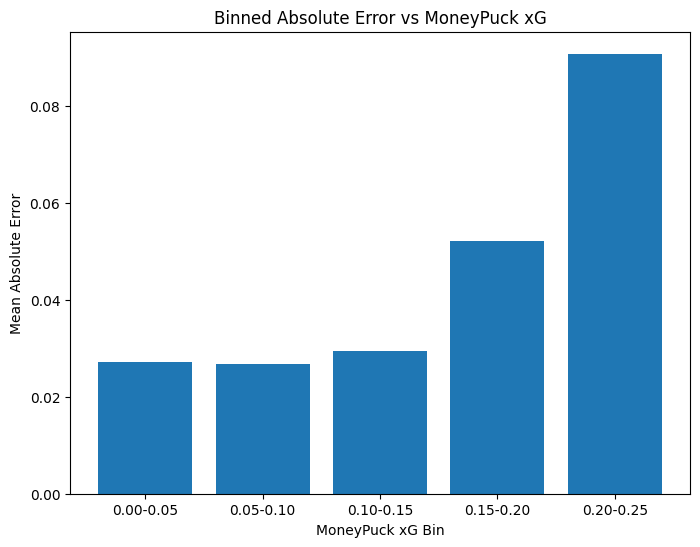

In [76]:
# binned summary
bins = np.linspace(0, 0.25, 6)
digitized = np.digitize(xgoal_test, bins)
mae_by_bin = [np.mean(abs_diff[digitized == i]) for i in range(1, len(bins))]

print("MSE vs MoneyPuck xG:", mean_squared_error(xgoal_test, y_prob))
print("MAE vs MoneyPuck xG:", mean_absolute_error(xgoal_test, y_prob))

plt.figure(figsize=(8,6))
plt.bar(range(len(mae_by_bin)), mae_by_bin, tick_label=[f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)])
plt.xlabel("MoneyPuck xG Bin")
plt.ylabel("Mean Absolute Error")
plt.title("Binned Absolute Error vs MoneyPuck xG")
plt.show()